# Estimación de la Inflación con ML

## Flujo Completo

Obtención de valores óptimos para los hiperparámetros usando todas las variables explicativas propuestas.

In [1]:
#Importación de librerías

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import get_scorer_names, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller

plt.style.use('ggplot')

In [2]:
#Importación de insumos

sabana_analitica = pd.read_csv('../sabana_analitica.csv', index_col = 'Periodo')
sabana_analitica.dropna(inplace = True)
sabana_analitica = sabana_analitica.iloc[:180,:]

In [3]:
# División de sábana entre variables explicativas y variable objetivo

X = sabana_analitica.iloc[:,1:]
y = sabana_analitica[['inpc']]

## División de dataset en train y test

In [4]:
#División secuencial entre TRAIN y TEST (debido a ser una serie de tiempo)

Xtrain = X.iloc[:-24]
ytrain = y.iloc[:-24]
Xtest = X.iloc[-24:]
ytest = y.iloc[-24:]

Obtención de índices para ejecución de Cross Validation en una serie de tiempo

In [58]:
tscv = TimeSeriesSplit(n_splits=5)

## Ejecución de Grid Search para Selección de Hiperparámetros

### Modelos Lineales

Creación y entrenamiento de modelos mediante Pipeline

In [59]:
#Regresión Lineal de Mínimos Cuadrados
linreg = Pipeline([
    ('scaler',StandardScaler()),
    ('linear',LinearRegression())
])
#Regresión de Ridge
ridreg = Pipeline([
    ('scaler',StandardScaler()),
    ('ridge',Ridge())
])
#Regresión de Lasso
lasreg = Pipeline([
    ('scaler',StandardScaler()),
    ('lasso',Lasso())
])

Definición de valores de HP a evaluar

In [60]:
param_grid_rid = {
    'ridge__alpha': [1, 10, 20, 50, 100]
}

param_grid_las = {
    'lasso__alpha': [0.0001, 0.0002, 0.0005, 0.001, 0.002]
}

Ejecución del Grid Search

In [61]:
ridreg_gs = GridSearchCV(ridreg, param_grid_rid, cv=tscv, scoring='neg_mean_squared_error')
lasreg_gs = GridSearchCV(lasreg, param_grid_las, cv=tscv, scoring='neg_mean_squared_error')

Entrenamiento de Modelos

In [62]:
ridreg_gs.fit(Xtrain,ytrain)
lasreg_gs.fit(Xtrain,ytrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.0001, 0.0002, 0.0005, 0.001,
                                          0.002]},
             scoring='neg_mean_squared_error')

Obtención de resultados del Grid Search

In [63]:
print('GRID SEARCH: Regresión Ridge')
print("Mejores parámetros:", ridreg_gs.best_params_)
print("Puntuación de la mejor configuración:", ridreg_gs.best_score_)

print('\n','GRID SEARCH: Regresión Lasso')
print("Mejores parámetros:", lasreg_gs.best_params_)
print("Puntuación de la mejor configuración:", lasreg_gs.best_score_)

GRID SEARCH: Regresión Ridge
Mejores parámetros: {'ridge__alpha': 50}
Puntuación de la mejor configuración: -8.785031942219067e-06

 GRID SEARCH: Regresión Lasso
Mejores parámetros: {'lasso__alpha': 0.0005}
Puntuación de la mejor configuración: -9.44101449961052e-06


### Análisis de lambdas propuestas para Ridge y LASSO

Ridge

In [64]:
# Extrayendo y preparando los resultados
cv_results = pd.DataFrame(ridreg_gs.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']

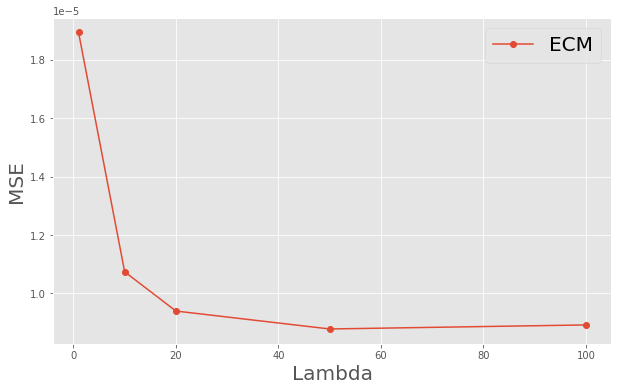

In [65]:
# Graficando
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_ridge__alpha'], cv_results['mean_test_score'], '-o', label='ECM')
plt.xlabel('Lambda', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.legend(fontsize = 20)

plt.savefig('lambda_ridge.png')

LASSO

In [66]:
# Extrayendo y preparando los resultados
cv_results = pd.DataFrame(lasreg_gs.cv_results_)
cv_results['mean_test_score'] = -cv_results['mean_test_score']

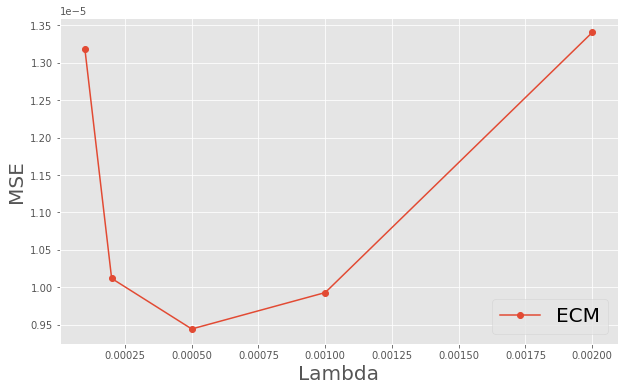

In [67]:
# Graficando
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_lasso__alpha'], cv_results['mean_test_score'], '-o', label='ECM')
plt.xlabel('Lambda', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.legend(fontsize = 20)

plt.savefig('lambda_lasso.png')

### Modelos No Lineales

Creación y entrenamiento de modelos mediante Pipeline

In [17]:
#Árbol de Decisión
dectre = Pipeline([
    ('scaler',StandardScaler()),
    ('dectre',DecisionTreeRegressor(criterion = 'squared_error', random_state = 100))
])

#Random Forest
ranfor = Pipeline([
    ('scaler',StandardScaler()),
    ('ranfor',RandomForestRegressor(criterion = 'squared_error', random_state = 100))
])

#XGBoost
xgbo = Pipeline([
    ('scaler',StandardScaler()),
    ('xgbo',xgb.XGBRegressor(random_state = 100))
])

Definición de valores de HP a evaluar

In [18]:
max_depth = [2, 4, 8, 20, None]
n_estimators = [20, 50, 100, 200, 500]
learning_rate = [0.1, 0.2, 0.5, 0.75, 1]

In [19]:
param_grid_dectre = {
    'dectre__max_depth':max_depth
}

param_grid_ranfor = {
    'ranfor__n_estimators': n_estimators,
    'ranfor__max_depth':max_depth
}

param_grid_xgbo = {
    'xgbo__n_estimators': n_estimators,
    'xgbo__learning_rate': learning_rate,
    'xgbo__max_depth':max_depth
}

Ejecución del Grid Search

In [20]:
dectre_gs = GridSearchCV(dectre, param_grid_dectre, cv=tscv, scoring='neg_mean_squared_error')
ranfor_gs = GridSearchCV(ranfor, param_grid_ranfor, cv=tscv, scoring='neg_mean_squared_error')
xgbo_gs = GridSearchCV(xgbo, param_grid_xgbo, cv=tscv, scoring='neg_mean_squared_error')

Entrenamiento de Modelos

In [21]:
dectre_gs.fit(Xtrain,ytrain)
ranfor_gs.fit(Xtrain,ytrain)
xgbo_gs.fit(Xtrain,ytrain)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgbo',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=Non...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=100, ...))]),
             param_grid={'xgbo__learning_rate': [0.1, 0.2, 0.5, 0.75, 1],
                         'xgbo__max_depth': [2, 4, 8, 20, None],
                         'xgbo__n_estimators': [20, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

Obtención de resultados del Grid Search

In [22]:
print('GRID SEARCH: Árbol de Decisión')
print("Mejores parámetros:", dectre_gs.best_params_)
print("Puntuación de la mejor configuración:", dectre_gs.best_score_)

print('GRID SEARCH: Random Forest')
print("Mejores parámetros:", ranfor_gs.best_params_)
print("Puntuación de la mejor configuración:", ranfor_gs.best_score_)

print('GRID SEARCH: XGBoost')
print("Mejores parámetros:", xgbo_gs.best_params_)
print("Puntuación de la mejor configuración:", xgbo_gs.best_score_)

GRID SEARCH: Árbol de Decisión
Mejores parámetros: {'dectre__max_depth': 2}
Puntuación de la mejor configuración: -9.402194965625457e-06
GRID SEARCH: Random Forest
Mejores parámetros: {'ranfor__max_depth': 20, 'ranfor__n_estimators': 100}
Puntuación de la mejor configuración: -7.700678946153846e-06
GRID SEARCH: XGBoost
Mejores parámetros: {'xgbo__learning_rate': 0.1, 'xgbo__max_depth': 2, 'xgbo__n_estimators': 50}
Puntuación de la mejor configuración: -8.20057727771084e-06


## Validación de Hiperparámetros Seleccionados

### Modelos Lineales

Creación de modelos con hiperparámetros optimizados

In [23]:
#Regresión Lineal de Mínimos Cuadrados
linreg_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('linear',LinearRegression())
])
#Regresión de Ridge
ridreg_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('ridge',Ridge(alpha = ridreg_gs.best_params_['ridge__alpha']))
])
#Regresión de Lasso
lasreg_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('lasso',Lasso(alpha = lasreg_gs.best_params_['lasso__alpha']))
])

Entrenamiento de modelos

In [24]:
linreg_opt.fit(Xtrain, ytrain)
ridreg_opt.fit(Xtrain, ytrain)
lasreg_opt.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.0005))])

Obtención de métricas de desempeño

In [25]:
#Obtención de predicciones usando modelos entrenados

predict_linreg = linreg_opt.predict(Xtest)
predict_ridreg = ridreg_opt.predict(Xtest)
predict_lasreg = lasreg_opt.predict(Xtest)

#Obtención de métricas por modelo

#Regresión Lineal
mse_linreg = mean_squared_error(ytest, predict_linreg)
mae_linreg = mean_absolute_error(ytest, predict_linreg)
r2_linreg = r2_score(ytrain, linreg_opt.predict(Xtrain))

#Regresión de Ridge
mse_ridreg = mean_squared_error(ytest, predict_ridreg)
mae_ridreg = mean_absolute_error(ytest, predict_ridreg)
r2_ridreg = r2_score(ytrain, ridreg_opt.predict(Xtrain))

#Regresión de Lasso
mse_lasreg = mean_squared_error(ytest, predict_lasreg)
mae_lasreg = mean_absolute_error(ytest, predict_lasreg)
r2_lasreg = r2_score(ytrain, lasreg_opt.predict(Xtrain))

In [28]:
print('Desempeño de Regresión Lineal')
print(f'MSE: {mse_linreg}')
print(f'MAE: {mae_linreg}')
print(f'R2: {r2_linreg}','\n')

print('Desempeño de Regresión de Ridge')
print(f'MSE: {mse_ridreg}')
print(f'MAE: {mae_ridreg}')
print(f'R2: {r2_ridreg}','\n')

print('Desempeño de Regresión Lasso')
print(f'MSE: {mse_lasreg}')
print(f'MAE: {mae_lasreg}')
print(f'R2: {r2_lasreg}','\n')

Desempeño de Regresión Lineal
MSE: 3.8574011386666004e-05
MAE: 0.0054002020568857875
R2: 0.8153427354907377 

Desempeño de Regresión de Ridge
MSE: 1.0060813937591026e-05
MAE: 0.002451532606111754
R2: 0.707447170213544 

Desempeño de Regresión Lasso
MSE: 5.129770659720225e-06
MAE: 0.001769781347739032
R2: 0.4704506777221632 



Graficación de resultados del test

<function matplotlib.pyplot.show(close=None, block=None)>

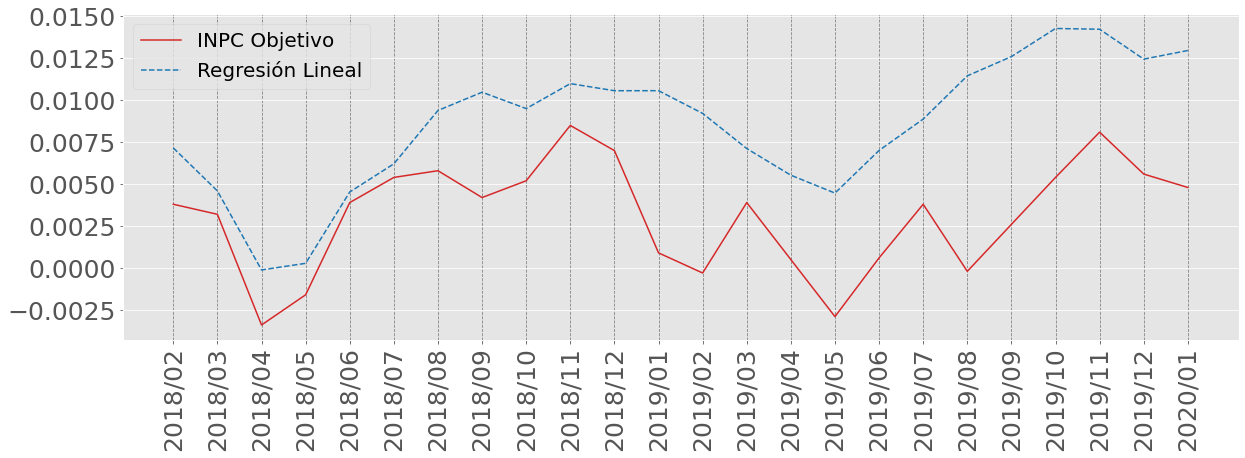

In [30]:
#REGRESIÓN LINEAL

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_linreg, color = 'tab:blue', label = 'Regresión Lineal', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_linreg.png', bbox_inches='tight')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

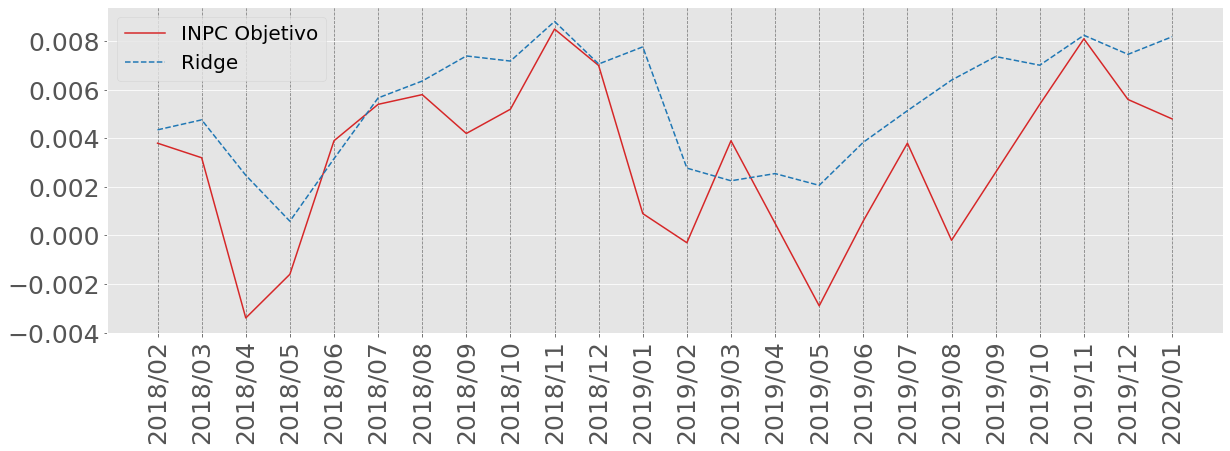

In [31]:
#RIDGE

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_ridreg, color = 'tab:blue', label = 'Ridge', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_ridreg.png', bbox_inches='tight')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

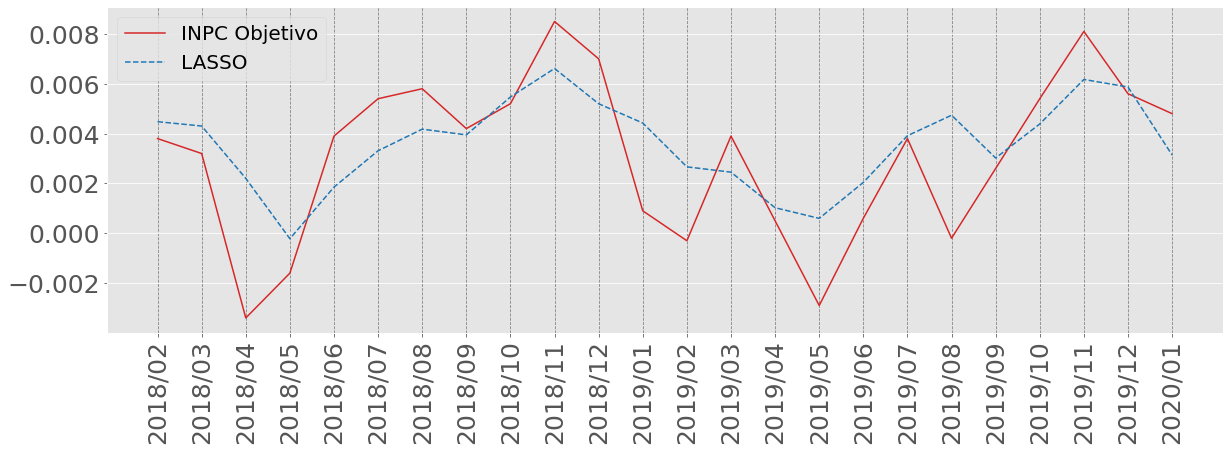

In [33]:
#LASSO

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_lasreg, color = 'tab:blue', label = 'LASSO', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_lasreg.png', bbox_inches='tight')

plt.show

### Modelos No Lineales

Creación de modelos con hiperparámetros optimizados

In [34]:
#Árbol de Decisión
dectre_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('dectre',DecisionTreeRegressor(criterion = 'squared_error', random_state = 100,
                                    max_depth = dectre_gs.best_params_['dectre__max_depth']))
])

#Random Forest
ranfor_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('ranfor',RandomForestRegressor(criterion = 'squared_error', random_state = 100,
                                    max_depth = ranfor_gs.best_params_['ranfor__max_depth'], 
                                    n_estimators = ranfor_gs.best_params_['ranfor__n_estimators']))
])

#XGBoost
xgbo_opt = Pipeline([
    ('scaler',StandardScaler()),
    ('xgbo',xgb.XGBRegressor(random_state = 100, 
                             max_depth = xgbo_gs.best_params_['xgbo__max_depth'], 
                             n_estimators = xgbo_gs.best_params_['xgbo__n_estimators'], 
                             learning_rate = xgbo_gs.best_params_['xgbo__learning_rate']))
])

In [35]:
dectre_opt.fit(Xtrain,ytrain)
ranfor_opt.fit(Xtrain,ytrain)
xgbo_opt.fit(Xtrain,ytrain)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbo',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=100, ...))])

Obtención de Métricas de Desempeño

In [36]:
#Obtención de predicciones usando modelos entrenados

predict_dectre = dectre_opt.predict(Xtest)
predict_ranfor = ranfor_opt.predict(Xtest)
predict_xgbo = xgbo_opt.predict(Xtest)

#Obtención de métricas por modelo

#Árbol de Decisión
mse_dectre = mean_squared_error(ytest, predict_dectre)
mae_dectre = mean_absolute_error(ytest, predict_dectre)
r2_dectre = r2_score(ytrain, dectre_opt.predict(Xtrain))

#Random Forest
mse_ranfor = mean_squared_error(ytest, predict_ranfor)
mae_ranfor = mean_absolute_error(ytest, predict_ranfor)
r2_ranfor = r2_score(ytrain, ranfor_opt.predict(Xtrain))

#XGBoost
mse_xgbo = mean_squared_error(ytest, predict_xgbo)
mae_xgbo = mean_absolute_error(ytest, predict_xgbo)
r2_xgbo = r2_score(ytrain, xgbo_opt.predict(Xtrain))

In [37]:
print('Desempeño de Árbol de Decisión')
print(f'MSE: {mse_dectre}')
print(f'MAE: {mae_dectre}')
print(f'R2: {r2_dectre}','\n')

print('Desempeño de Random Forest')
print(f'MSE: {mse_ranfor}')
print(f'MAE: {mae_ranfor}')
print(f'R2: {r2_ranfor}','\n')

print('Desempeño de XGBoost')
print(f'MSE: {mse_xgbo}')
print(f'MAE: {mae_xgbo}')
print(f'R2: {r2_xgbo}','\n')

Desempeño de Árbol de Decisión
MSE: 7.166314090266209e-06
MAE: 0.0018900042517006803
R2: 0.5481913458508054 

Desempeño de Random Forest
MSE: 9.462812291666668e-06
MAE: 0.0021222083333333336
R2: 0.9393473998000842 

Desempeño de XGBoost
MSE: 7.081150939385207e-06
MAE: 0.0020162125330263126
R2: 0.8715430356723306 



Graficación de resultados del test

<function matplotlib.pyplot.show(close=None, block=None)>

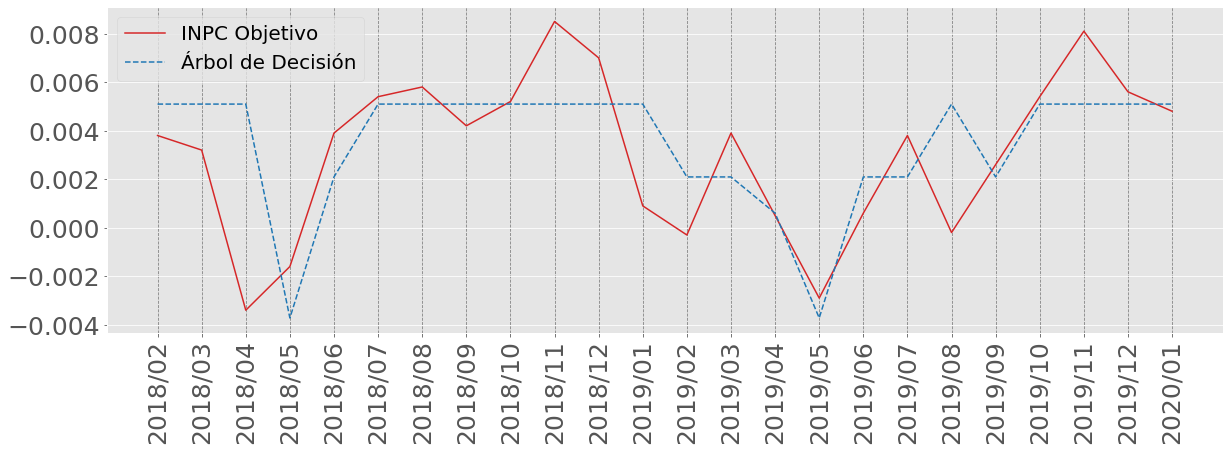

In [38]:
#ÁRBOL DE DECISIÓN

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_dectre, color = 'tab:blue', label = 'Árbol de Decisión', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_dectre.png', bbox_inches='tight')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

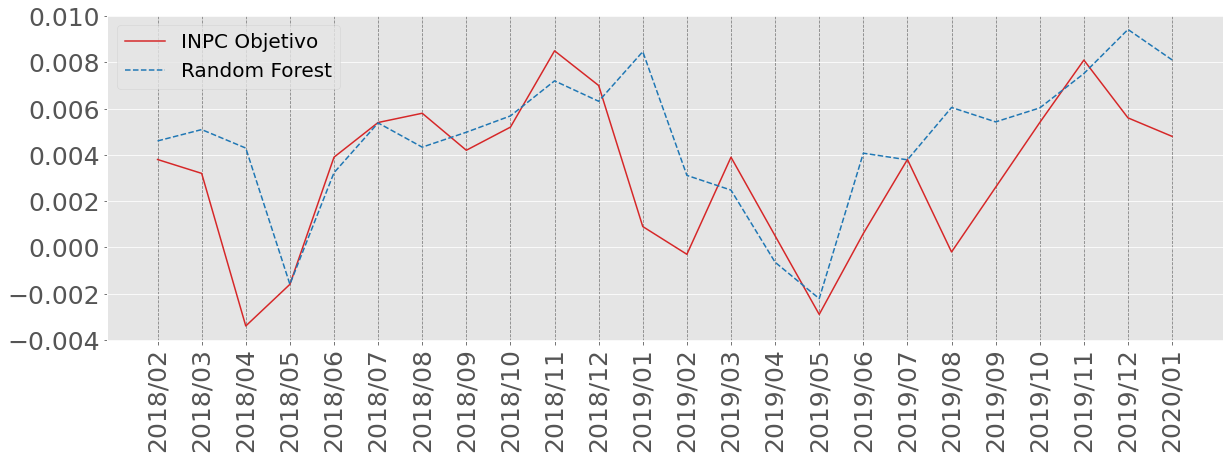

In [39]:
#RANDOM FOREST

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_ranfor, color = 'tab:blue', label = 'Random Forest', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_ranfor.png', bbox_inches='tight')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

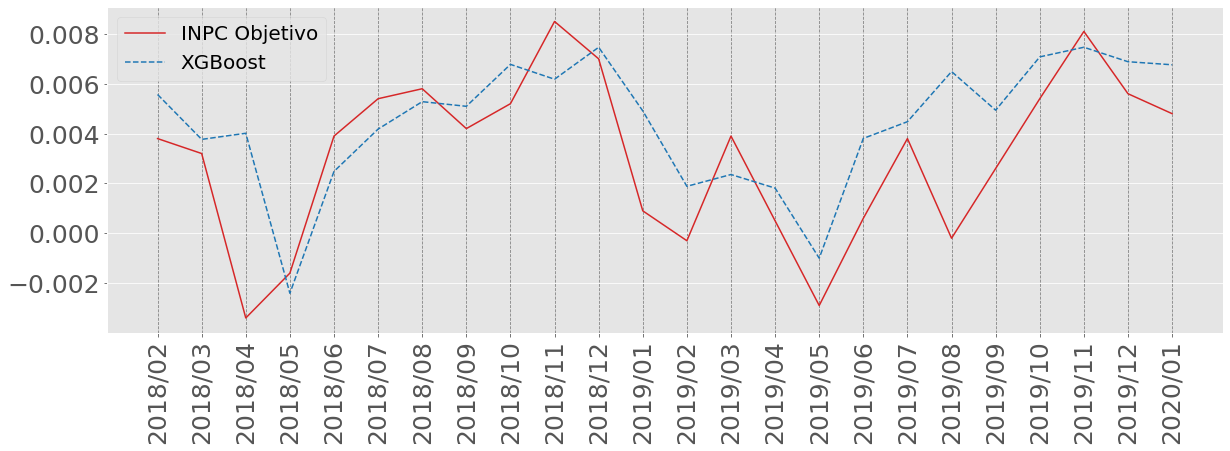

In [40]:
#XGBOOST

fig, ax = plt.subplots()

ax.plot(ytest.index, ytest['inpc'], color = 'tab:red', label = 'INPC Objetivo')
ax.plot(ytest.index, predict_xgbo, color = 'tab:blue', label = 'XGBoost', linestyle = 'dashed')

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(6)

ax.set_xticks(np.arange(0, len(ytest.index), 1))
ax.grid(axis = 'x', color = 'gray', linestyle = 'dashed')

ax.legend(loc = 'upper left', fontsize = 20)

plt.yticks(fontsize=25)
plt.xticks(rotation=90, fontsize=25)

plt.savefig('pred_xgboost.png', bbox_inches='tight')

plt.show

## Comparación vs Regresión Lineal

In [343]:
def dism_error_estimacion(metrica1, metrica2):
    return (metrica1 - metrica2)/metrica1

MSE

In [344]:
#Ridge

dism_error_estimacion(mse_linreg, mse_ridreg)

0.7391815479924709

In [345]:
#LASSO

dism_error_estimacion(mse_linreg, mse_lasreg)

0.8670148507942461

In [346]:
#Árbol de Decisión

dism_error_estimacion(mse_linreg, mse_dectre)

0.814219111970724

In [347]:
#Random Forest

dism_error_estimacion(mse_linreg, mse_ranfor)

0.7546842562778496

In [348]:
#XGBoost

dism_error_estimacion(mse_linreg, mse_xgbo)

0.8164268976746097

In [355]:
#RIDGE VS LASSO

dism_error_estimacion(mse_ridreg, mse_lasreg)

0.49012369262158284

In [358]:
#Bosque vs Árbol

dism_error_estimacion(mse_ranfor, mse_dectre)

0.24268664860052722

In [360]:
#XGB vs Árbol

dism_error_estimacion(mse_xgbo, mse_dectre)

-0.012026738535868055

MAE

In [349]:
#Ridge

dism_error_estimacion(mae_linreg, mae_ridreg)

0.5460294669926639

In [350]:
#LASSO

dism_error_estimacion(mae_linreg, mae_lasreg)

0.6722749761775326

In [351]:
#Árbol de Decisión

dism_error_estimacion(mae_linreg, mae_dectre)

0.6500123084670991

In [352]:
#Random Forest

dism_error_estimacion(mae_linreg, mae_ranfor)

0.6070131615487777

In [353]:
#XGBoost

dism_error_estimacion(mae_linreg, mae_xgbo)

0.626641279013728

In [354]:
#RIDGE VS LASSO

dism_error_estimacion(mae_ridreg, mae_lasreg)

0.2780918584044499

In [356]:
#Bosque vs Árbol

dism_error_estimacion(mae_ranfor, mae_dectre)

0.10941625192279422

In [357]:
#XGB vs Árbol

dism_error_estimacion(mae_xgbo, mae_dectre)

0.06259671500811231

## Sesgo y Varianza

Método de Varianza Estadística de las predicciones

In [41]:
def varianza_predicciones_scorer(y_true, y_pred):
    media_predicciones = np.mean(y_pred)
    varianza = np.mean((y_pred - media_predicciones) ** 2)
    return varianza

scorer_variance_predicts = make_scorer(varianza_predicciones_scorer, greater_is_better=False)

In [42]:
#Regresión Lineal

scores_linreg_bias = cross_val_score(linreg_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_linreg_var = cross_val_score(linreg_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_linreg = -np.mean(scores_linreg_bias)
variance_linreg = -np.mean(scores_linreg_var)

In [43]:
#Regresión Ridge

scores_ridreg_bias = cross_val_score(ridreg_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_ridreg_var = cross_val_score(ridreg_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_ridreg = -np.mean(scores_ridreg_bias)
variance_ridreg = -np.mean(scores_ridreg_var)

In [44]:
#Regresión Lasso

scores_lasreg_bias = cross_val_score(lasreg_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_lasreg_var = cross_val_score(lasreg_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_lasreg = -np.mean(scores_lasreg_bias)
variance_lasreg = -np.mean(scores_lasreg_var)

In [45]:
#Árbol de Decisión

scores_dectre_bias = cross_val_score(dectre_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_dectre_var = cross_val_score(dectre_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_dectre = -np.mean(scores_dectre_bias)
variance_dectre = -np.mean(scores_dectre_var)

In [46]:
#Random Forest

scores_ranfor_bias = cross_val_score(ranfor_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_ranfor_var = cross_val_score(ranfor_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_ranfor = -np.mean(scores_ranfor_bias)
variance_ranfor = -np.mean(scores_ranfor_var)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Library/Frameworks/Python.framework/Versio

In [47]:
#XGBoost

scores_xgbo_bias = cross_val_score(xgbo_opt, Xtrain, ytrain, cv=tscv, scoring='neg_mean_squared_error')
scores_xgbo_var = cross_val_score(xgbo_opt, Xtrain, ytrain, cv=tscv, scoring=scorer_variance_predicts)

bias_squared_xgbo = -np.mean(scores_xgbo_bias)
variance_xgbo = -np.mean(scores_xgbo_var)

Graficación de Sesgo vs Varianza

In [48]:
sesgos = [bias_squared_linreg, bias_squared_ridreg, bias_squared_lasreg,
          bias_squared_dectre, bias_squared_ranfor, bias_squared_xgbo]

In [49]:
varianzas = [variance_linreg, variance_ridreg, variance_lasreg,
             variance_dectre, variance_ranfor, variance_xgbo]

In [50]:
clases = ['Regresión lineal','Ridge','LASSO',
          'Árbol de decisión','Bosque Aleatorio','XGBoost']

colores = ['red', 'dodgerblue', 'yellow', 'limegreen', 'cyan', 'orange']

<function matplotlib.pyplot.show(close=None, block=None)>

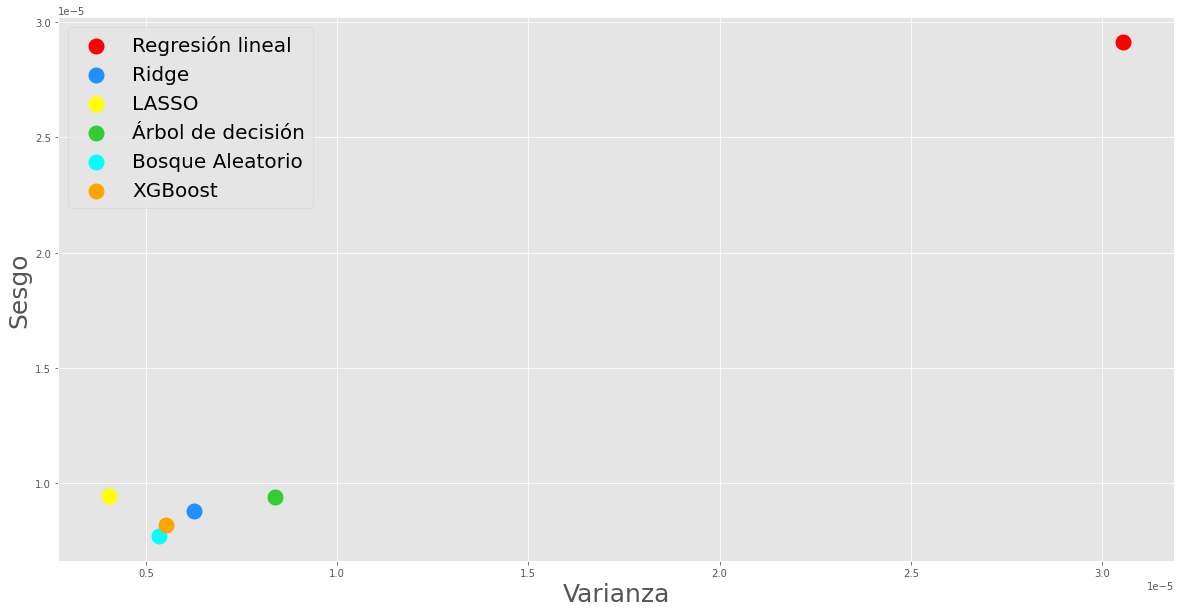

In [52]:
#SESGO VS VARIANZA

fig, ax = plt.subplots()

fig.set_figwidth(20)  # Ancho de la figura en pulgadas
fig.set_figheight(10)

for i in range(len(varianzas)):
    ax.scatter(varianzas[i], sesgos[i], color=colores[i],label=clases[i], linewidths = 10)
    
ax.legend(loc = 'upper left', fontsize = 20)

plt.xlabel('Varianza', fontsize = 25)
plt.ylabel('Sesgo', fontsize = 25)

plt.savefig('var_bias.png', bbox_inches='tight')

plt.show